## Setup

In [1]:
%load_ext autoreload
%autoreload 2

# TODO remove
import sys,os
sys.path.append(os.path.expanduser('~/imodels'))
sys.path.append(os.path.expanduser('~/dtreeviz'))

########################################################
# python

import os
import time
import pandas as pd
import numpy as np
import scipy.stats
norm = scipy.stats.norm
import bisect
import warnings
# not working
# warnings.filterwarnings('ignore', category=DeprecationWarning) # , message='the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead')

########################################################
# figs (imodels), xgboost, sklearn

import imodels
from imodels import FIGSClassifier

import xgboost as xgb

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.inspection import permutation_importance

########################################################
# dtreeviz
# must follow the package README to properly install all dependencies!

from dtreeviz import trees
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree
from imodels.tree.viz_utils import extract_sklearn_tree_from_figs
from dtreeviz.colors import mpl_colors

from wand.image import Image
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF

########################################################
# skompiler

from skompiler import skompile

########################################################
# plotting

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

warnings.filterwarnings('ignore', message='Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.')
warnings.filterwarnings('ignore', message="urllib3 (1.26.12) or chardet (None)/charset_normalizer (3.0.0) doesn't match a supported version!")

########################################################
# set global rnd_seed for reproducibility

rnd_seed = 42
np.random.seed(rnd_seed)

datasets = ['train', 'holdout']

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
from plotting import * # load plotting code

In [3]:
inline=False # plot inline or to pdf
output = './output_figs_demo' # output dir
os.makedirs(output, exist_ok=True)

In [4]:
def save_dtreeviz(viz, m_path, fname, tag='', inline=inline, svg=False, png=False, pdf=True):
    if inline:
        display(viz)
    else:
        if not (svg or png or pdf):
            warnings.warn('Not saving anything!')

        os.makedirs(m_path, exist_ok=True)
        full_path = f'{m_path}/{fname}{tag}'

        # svg
        viz.save(f'{full_path}.svg')

        # pdf via svglib
        if pdf:
            renderPDF.drawToFile(svg2rlg(f'{full_path}.svg'), f'{full_path}.pdf')

        # png via wand / ImageMagick
        if png:
            img = Image(filename=f'{full_path}.svg', resolution=500)
            img.format = 'png'
            img.save(filename=f'{full_path}.png')

        if not svg:
            # clean up svg
            os.remove(f'{full_path}.svg')

        # clean up graphviz dot file (no extension)
        os.remove(full_path)

In [5]:
def save_plt(m_path, fname, tag='', inline=inline):
    plt.tight_layout()
    if inline:
        plt.show()
    else:
        os.makedirs(m_path, exist_ok=True)
        plt.savefig(f'{m_path}/{fname}{tag}.pdf')
        plt.close('all')

***
# Generate Random Data
Include additive structure that FIGS does well on

In [6]:
mc_params_all = {'n_samples': int(1e5), 'n_classes': 2, 'shuffle': False, 'shift': 0.0, 'scale': 1.0, 'hypercube': True}

mc_params = [
    {'n_features': 20, 'n_informative': 6, 'n_redundant': 4, 'n_repeated': 0,
     'n_clusters_per_class': 5, 'weights': [0.5], 'flip_y': 0.05, 'class_sep': 0.9},
    {'n_features': 10, 'n_informative': 4, 'n_redundant': 2, 'n_repeated': 0,
     'n_clusters_per_class': 2, 'weights': [0.7], 'flip_y': 0.1, 'class_sep': 0.9},
    {'n_features': 5, 'n_informative': 2, 'n_redundant': 2, 'n_repeated': 0,
     'n_clusters_per_class': 2, 'weights': [0.6], 'flip_y': 0.04, 'class_sep': 0.9},
]

X = None
y = None
feat_names = []

for i_mc_param, mc_param in enumerate(mc_params):
    param = {**mc_params_all, **mc_param, 'random_state': rnd_seed+i_mc_param}
    X_i, y_i = make_classification(**param)
    if X is None:
        X = X_i
    else:
        X = np.concatenate([X, X_i], axis=1)
    if y is None:
        y = y_i
    else:
        y = np.logical_and(y, y_i).astype(int)
    feat_names += [f'x_{i_mc_param}_{_}' for _ in range(X_i.shape[1])]
    del X_i; del y_i;

Make Train, Validation, and Holdout Sets

In [7]:
X_trainVal, X_holdout, y_trainVal, y_holdout = train_test_split(X, y, test_size=0.15, random_state=rnd_seed, stratify=y)
del X; del y;

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.2, random_state=rnd_seed, stratify=y_trainVal)
# del X_trainVal; del y_trainVal;

***
# FIGS
Note we are not using early stopping with FIGS, so use `X_trainVal` during training to take advantage of all rows.

In [8]:
model_figs = FIGSClassifier(max_rules=20)

In [9]:
time_figs_start = time.time()
model_figs.fit(X_trainVal, y_trainVal, feature_names=feat_names);
time_figs_end = time.time()
print(f'FIGS ran in {time_figs_end-time_figs_start:.0f} seconds')

FIGS ran in 15 seconds


In [10]:
def count_splits_figs(model):
    splits = []
    for tree_ in model.trees_:
        node_counter = iter(range(1, int(1e06)))
        def _count_node(node):
            if node.left is None:
                return
            node_id=next(node_counter)
            _count_node(node.left)
            _count_node(node.right)

        _count_node(tree_)
        splits.append(next(node_counter)-1)
    return sum(splits)

n_splits_figs = count_splits_figs(model_figs)

In [11]:
print(f'FIGS used {len(model_figs.trees_)} trees and {n_splits_figs:,} splits')

FIGS used 2 trees and 20 splits


In [12]:
print(model_figs)

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
x_2_1 <= 0.048 (Tree #0 root)
	x_2_0 <= -0.608 (split)
		x_1_4 <= 0.018 (split)
			x_0_7 <= 1.400 (split)
				Val: 0.125 (leaf)
				Val: 0.377 (leaf)
			Val: 0.052 (leaf)
		Val: 0.019 (leaf)
	x_0_8 <= 2.363 (split)
		x_0_7 <= 1.870 (split)
			Val: 0.181 (leaf)
			Val: 0.366 (leaf)
		x_1_0 <= 0.339 (split)
			x_2_0 <= -0.046 (split)
				Val: 0.423 (leaf)
				Val: 0.688 (leaf)
			x_1_1 <= 2.087 (split)
				Val: 0.227 (leaf)
				Val: 0.502 (leaf)

	+
x_0_2 <= -0.432 (Tree #1 root)
	Val: -0.040 (leaf)
	x_0_3 <= 0.455 (split)
		Val: -0.015 (leaf)
		x_2_1 <= -0.317 (split)
			Val: 0.013 (leaf)
			x_1_3 <= -0.299 (split)
				x_0_0 <= -0.958 (split)
					x_1_2 <= 0.359 (split)
						Val: -0.021 (leaf)
						Val: 0.437 (leaf)
					x_2_0 <= 0.152 (split)
						Val: 0.414 (leaf)
						Val: 0.214 (leaf)
				x_1_4 

In [13]:
print(model_figs.print_tree(X_train, y_train))

------------
x_2_1 <= 0.048 9694/68000 (14.26%)
	x_2_0 <= -0.608 1205/41959 (2.87%)
		x_1_4 <= 0.018 1139/17540 (6.49%)
			x_0_7 <= 1.400 693/3569 (19.42%)
				ΔRisk = 0.13 286/2525 (11.33%)
				ΔRisk = 0.38 407/1044 (38.98%)
			ΔRisk = 0.05 446/13971 (3.19%)
		ΔRisk = 0.02 66/24419 (0.27%)
	x_0_8 <= 2.363 8489/26041 (32.6%)
		x_0_7 <= 1.870 4371/19070 (22.92%)
			ΔRisk = 0.18 2504/13936 (17.97%)
			ΔRisk = 0.37 1867/5134 (36.37%)
		x_1_0 <= 0.339 4118/6971 (59.07%)
			x_2_0 <= -0.046 3206/4510 (71.09%)
				ΔRisk = 0.42 540/1055 (51.18%)
				ΔRisk = 0.69 2666/3455 (77.16%)
			x_1_1 <= 2.087 912/2461 (37.06%)
				ΔRisk = 0.23 462/1698 (27.21%)
				ΔRisk = 0.50 450/763 (58.98%)

	+
x_0_2 <= -0.432 9694/68000 (14.26%)
	ΔRisk = -0.04 1458/28479 (5.12%)
	x_0_3 <= 0.455 8236/39521 (20.84%)
		ΔRisk = -0.01 3164/21232 (14.9%)
		x_2_1 <= -0.317 5072/18289 (27.73%)
			ΔRisk = 0.01 354/8539 (4.15%)
			x_1_3 <= -0.299 4718/9750 (48.39%)
				x_0_0 <= -0.958 3026/5107 (59.25%)
					x_1_2 <= 0.359 41

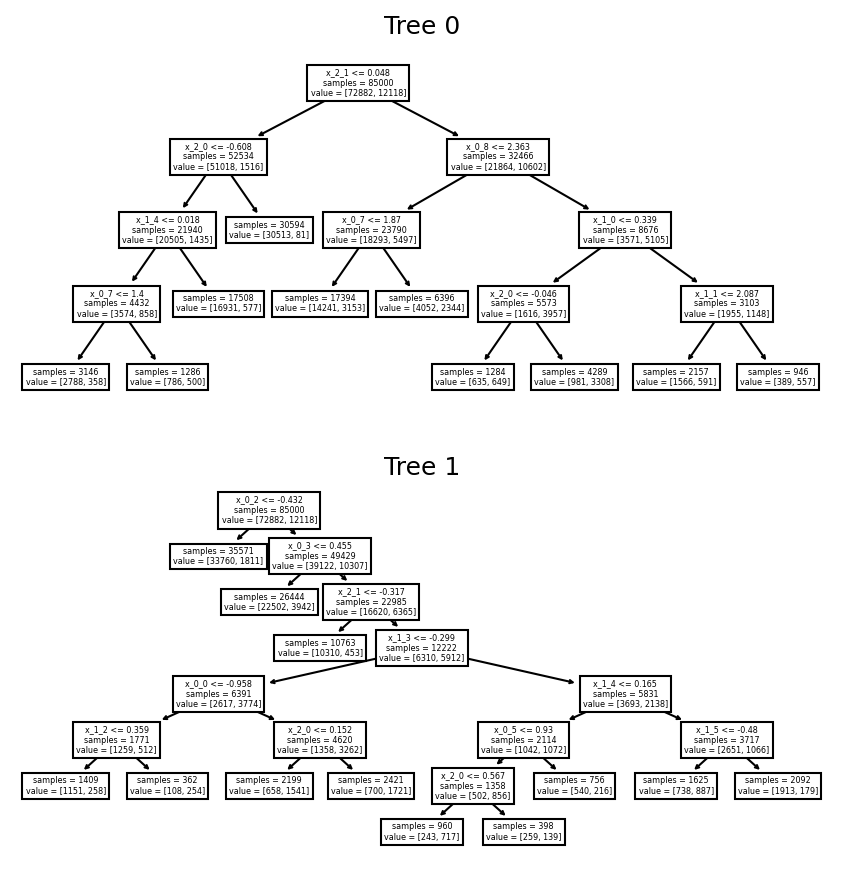

In [14]:
model_figs.plot(fig_size=7)

***
# XGBoost

In [15]:
params_default = {'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}

In [16]:
fixed_setup_params = {
    'max_num_boost_rounds': 500, # maximum number of boosting rounds to run / trees to create
    'xgb_objective': 'binary:logistic', # objective function for binary classification
    'xgb_verbosity': 0, #  The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    'xgb_n_jobs': -1, # Number of parallel threads used to run XGBoost. -1 makes use of all cores in your system
    'eval_metric': 'auc', # evaluation metric for early stopping
    'early_stopping_rounds': 10, # must see improvement over last num_early_stopping_rounds or will halt
}

In [17]:
fixed_fit_params = {
    'eval_set': [(X_val, y_val)], # data sets to use for early stopping evaluation
    'verbose': False, # even more verbosity control
}

In [18]:
model_xgboost = xgb.XGBClassifier(n_estimators=fixed_setup_params['max_num_boost_rounds'],
                                  objective=fixed_setup_params['xgb_objective'],
                                  verbosity=fixed_setup_params['xgb_verbosity'],
                                  eval_metric=fixed_setup_params['eval_metric'],
                                  early_stopping_rounds=fixed_setup_params['early_stopping_rounds'],
                                  random_state=rnd_seed+3, **params_default)

In [19]:
time_xgboost_start = time.time()
model_xgboost.fit(X_train, y_train, **fixed_fit_params);
time_xgboost_end = time.time()
print(f'XGBoost ran in {time_xgboost_end-time_xgboost_start:.0f} seconds')

XGBoost ran in 3 seconds


In [20]:
n_splits_xgboost = sum([tree.count('"split"') for tree in model_xgboost.get_booster().get_dump(dump_format='json')[0:model_xgboost.best_ntree_limit]])

In [21]:
print(f'XGBoost used {model_xgboost.best_ntree_limit} trees and {n_splits_xgboost:,} splits')

XGBoost used 58 trees and 2,767 splits


***
# Evaluate

## Setup

In [22]:
def classifier_metrics(model, model_nname, X_train, y_train, X_holdout, y_holdout, feature_names, do_permutation_importance=True, print_classification_report=False):
    model_metrics = {'nname': model_nname}
    dfp_importance = pd.DataFrame({'feature': feature_names})
    dfp_importance['icolX'] = dfp_importance.index

    for dataset in datasets[::-1]:
        if dataset == 'holdout':
            X = X_holdout
            y = y_holdout
        elif dataset == 'train':
            X = X_train
            y = y_train
        y_pred = model.predict(X)
        # only want positive class prob
        try:
            # use best_iteration for XGBoost
            y_pred_prob = model.predict_proba(X, iteration_range=(0, model.best_iteration+1))[:, 1]
        except:
            y_pred_prob = model.predict_proba(X)[:, 1]

        model_metrics[dataset] = {}
        model_metrics[dataset]['accuracy_score'] = metrics.accuracy_score(y, y_pred)
        model_metrics[dataset]['precision_score'] = metrics.precision_score(y, y_pred, zero_division=0) # zero_division=0 hides divide by zero warnings that come up with LR doesn't converge
        model_metrics[dataset]['recall_score'] = metrics.recall_score(y, y_pred)
        model_metrics[dataset]['f1_score'] = metrics.f1_score(y, y_pred)
        model_metrics[dataset]['roc_auc_score'] = metrics.roc_auc_score(y, y_pred_prob)
        model_metrics[dataset]['average_precision_score'] = metrics.average_precision_score(y, y_pred_prob) # PR ROC AUC
        model_metrics[dataset]['log_loss'] = metrics.log_loss(y, y_pred)
        model_metrics[dataset]['cohen_kappa_score'] = metrics.cohen_kappa_score(y, y_pred)
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        CM = metrics.confusion_matrix(y, y_pred)
        model_metrics[dataset]['confusion_matrix'] = CM
        model_metrics[dataset]['TN'] = CM[0][0]
        model_metrics[dataset]['FP'] = CM[0][1]
        model_metrics[dataset]['FN'] = CM[1][0]
        model_metrics[dataset]['TP'] = CM[1][1]
        model_metrics[dataset]['TNR'] = CM[0][0] / (CM[0][0] + CM[0][1]) # TN / (TN + FP)
        model_metrics[dataset]['NPV'] = CM[0][0] / (CM[0][0] + CM[1][0]) # TN / (TN + FN)

        model_metrics[dataset]['pop_PPV'] = len(np.where(y == 1)[0]) / len(y) # P / (P + N)

        # model_metrics[dataset]['dfp_y'] = pd.DataFrame( {'y': y, 'y_pred_prob': y_pred_prob, 'y_pred': y_pred} )

        # for LR models
        # model_converged = (model.n_iter_ < model.max_iter)[0]

        if print_classification_report:
            print(f'For {dataset}:')
            print(metrics.classification_report(y, y_pred))

        # ROC Curves
        def get_n_predicted_positive_vs_thr(y_pred_prob, thr):
            y_pred_prob_sorted = sorted(y_pred_prob)
            return [len(y_pred_prob_sorted) - bisect.bisect_left(y_pred_prob_sorted, _thr) for _thr in thr]

        fpr, tpr, thr_of_fpr_tpr = roc_curve(y, y_pred_prob)
        n_predicted_positive_vs_thr_of_fpr_tpr = get_n_predicted_positive_vs_thr(y_pred_prob, thr_of_fpr_tpr)
        dfp_eval_fpr_tpr = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thr': thr_of_fpr_tpr, 'n_predicted_positive': n_predicted_positive_vs_thr_of_fpr_tpr}).sort_values(by='thr').reset_index(drop=True)

        precision, recall, thr_of_precision_recall = precision_recall_curve(y, y_pred_prob)
        thr_of_precision_recall = np.insert(thr_of_precision_recall, 0, [0])
        n_predicted_positive_vs_thr_of_precision_recall = get_n_predicted_positive_vs_thr(y_pred_prob, thr_of_precision_recall)
        dfp_eval_precision_recall = pd.DataFrame({'precision': precision, 'recall': recall, 'thr': thr_of_precision_recall, 'n_predicted_positive': n_predicted_positive_vs_thr_of_precision_recall})
        dfp_eval_precision_recall['f1'] = 2*(dfp_eval_precision_recall['precision'] * dfp_eval_precision_recall['recall']) / (dfp_eval_precision_recall['precision'] + dfp_eval_precision_recall['recall'])

        model_metrics[dataset]['dfp_eval_fpr_tpr'] = dfp_eval_fpr_tpr
        model_metrics[dataset]['dfp_eval_precision_recall'] = dfp_eval_precision_recall

        roc_entry = {'name': f'{model_nname.lower()}_{dataset}',
                     'nname': f'{model_nname} ({dataset.title()})',
                     'dfp_eval_fpr_tpr': dfp_eval_fpr_tpr,
                     'dfp_eval_precision_recall': dfp_eval_precision_recall
                    }
        if dataset == 'holdout':
            roc_entry['c'] = 'C2'
            roc_entry['ls'] = '-'
        else:
            roc_entry['c'] = 'black'
            roc_entry['ls'] = ':'

        model_metrics[dataset]['roc_entry'] = roc_entry

        if do_permutation_importance:
            # print('Start do_permutation_importance func')
            # Permutation feature importance
            # slow for thousands of features!
            # https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
            # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
            # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
            # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
            _permutation_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc')
            # print('End permutation_importance func')

            importance_permutation_mean = _permutation_importance['importances_mean']
            importance_permutation_std = _permutation_importance['importances_std']
            dfp_importance_permutation = pd.DataFrame({f'importance_permutation_{dataset}_mean': importance_permutation_mean, f'importance_permutation_{dataset}_std': importance_permutation_std})
            dfp_importance_permutation['icolX'] = dfp_importance_permutation.index
            dfp_importance_permutation[f'importance_permutation_{dataset}_pct'] = dfp_importance_permutation[f'importance_permutation_{dataset}_mean'].rank(pct=True)
            dfp_importance = pd.merge(dfp_importance, dfp_importance_permutation, on='icolX', how='left')

    # for LR models
    # dfp_coef = pd.DataFrame({'coefficients': model.coef_[0]})
    # dfp_coef['abs_coeff'] = dfp_coef['coefficients'].abs()
    # dfp_coef['icolX'] = dfp_coef.index
    # dfp_importance = pd.merge(dfp_importance, dfp_coef, on='icolX', how='left')

    # TODO
    # Gini impurity importance - a mean decrease in impurity (MDI) importance (both RF and BDT)
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_
    # importances_gini = model.feature_importances_
    # estimators = model.estimators_
    # importances_gini_std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    # dfp_importance_gini = pd.DataFrame({'importance_gini': importances_gini, 'importance_gini_std': importances_gini_std})
    # dfp_importance_gini['icolX'] = dfp_importance_gini.index
    # dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)
    # dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='icolX', how='left')

    target_cols_importance = [
        'feature',
        # 'coefficients',
        'importance_permutation_holdout_mean',
        'importance_permutation_holdout_std',
        'importance_permutation_holdout_pct',
        'importance_permutation_train_mean',
        'importance_permutation_train_std',
        'importance_permutation_train_pct',
        # 'importance_gini',
        # 'importance_gini_std',
        # 'importance_gini_pct',
        'icolX',
        # 'abs_coeff',
    ]
    _cols = [_col for _col in target_cols_importance if _col in dfp_importance.columns] + [_col for _col in dfp_importance.columns if _col not in target_cols_importance]
    dfp_importance = dfp_importance[_cols]
    if 'importance_permutation_holdout_mean' in dfp_importance.columns:
        sort_col = 'importance_permutation_holdout_mean'
    elif 'importance_gini' in dfp_importance.columns:
        sort_col = 'importance_gini'
    else:
        sort_col = 'icolX'
    dfp_importance = dfp_importance.sort_values(by=sort_col, ascending=False).reset_index(drop=True)

    dfp_importance = dfp_importance.drop(['icolX'], axis=1)
    # if 'abs_coeff' in dfp_importance.columns:
    #     dfp_importance = dfp_importance.drop(['abs_coeff'], axis=1)

    model_metrics['dfp_importance'] = dfp_importance

    return model_metrics

## Metrics

In [23]:
model_metrics_figs = classifier_metrics(model_figs, 'FIGS', X_trainVal, y_trainVal, X_holdout, y_holdout, feat_names)
model_metrics_xgboost = classifier_metrics(model_xgboost, 'XGBoost', X_train, y_train, X_holdout, y_holdout, feat_names)

metric_rows = []
for model_metrics in [model_metrics_figs, model_metrics_xgboost]:
    roc_entries = []
    for idataset,dataset in enumerate(datasets[::-1]):
        dataset_metrics = {'model': model_metrics['nname'], 'dataset': dataset}
        for k,v in model_metrics[dataset].items():
            if k == 'roc_entry':
                if 0 < len(roc_entries):
                    v['name'] = dataset
                roc_entries.append(v)
            elif k not in ['confusion_matrix', 'dfp_eval_fpr_tpr', 'dfp_eval_precision_recall', 'dfp_y']:
                dataset_metrics[k] = v
        metric_rows.append(dataset_metrics)

    plot_rocs(roc_entries, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, inline=False)
    plot_rocs(roc_entries, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, precision_recall=True,
              pop_PPV=model_metrics['holdout']['pop_PPV'], y_axis_params={'min': -0.05}, inline=False)

dfp_metrics = pd.DataFrame(metric_rows)
dfp_metrics = dfp_metrics.sort_values(by=['model', 'dataset'], ascending=[True, True]).reset_index(drop=True)
display(dfp_metrics)

,model,dataset,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,average_precision_score,log_loss,cohen_kappa_score,TN,FP,FN,TP,TNR,NPV,pop_PPV
0,FIGS,holdout,0.898067,0.712491,0.477549,0.571829,0.911709,0.634618,3.520675,0.516522,12450,412,1117,1021,0.967968,0.917668,0.142533
1,FIGS,train,0.901729,0.733416,0.488117,0.586137,0.914569,0.650357,3.394166,0.532920,70732,2150,6203,5915,0.970500,0.919373,0.142565
2,XGBoost,holdout,0.946467,0.845676,0.763798,0.802654,0.974239,0.844879,1.848992,0.771780,12564,298,505,1633,0.976831,0.961359,0.142533
3,XGBoost,train,0.968147,0.904470,0.868269,0.886000,0.990188,0.946239,1.100172,0.867496,57417,889,1277,8417,0.984753,0.978243,0.142559


In [24]:
print(f'XGBoost used {n_splits_xgboost:,} splits vs FIGS {n_splits_figs:,}')
print(f'That is {n_splits_xgboost-n_splits_figs:,}, or {(n_splits_xgboost-n_splits_figs)/n_splits_figs:,.0%}, more splits!')

XGBoost used 2,767 splits vs FIGS 20
That is 2,747, or 13,735%, more splits!


## Feature Importances

In [25]:
print('FIGS Feature Importances')
_dfp = model_metrics_figs['dfp_importance']
display(_dfp.loc[0 < _dfp['importance_permutation_holdout_mean']])

FIGS Feature Importances


,feature,importance_permutation_holdout_mean,importance_permutation_holdout_std,importance_permutation_holdout_pct,importance_permutation_train_mean,importance_permutation_train_std,importance_permutation_train_pct
0,x_2_1,0.281633,0.005927,1.000000,0.283036,0.001755,1.000000
1,x_1_4,0.026162,0.002426,0.971429,0.029008,0.000799,0.942857
2,x_2_0,0.026032,0.001159,0.942857,0.029866,0.000498,0.971429
3,x_0_2,0.024550,0.001272,0.914286,0.023949,0.000588,0.914286
4,x_1_3,0.020139,0.001193,0.885714,0.018275,0.000573,0.857143
5,x_0_8,0.019467,0.001028,0.857143,0.022575,0.000350,0.885714
6,x_0_3,0.014895,0.001420,0.828571,0.014720,0.000550,0.800000
7,x_0_7,0.013435,0.000675,0.800000,0.015834,0.000490,0.828571
8,x_1_5,0.008601,0.000907,0.771429,0.007197,0.000228,0.742857
9,x_1_0,0.007383,0.000489,0.742857,0.008384,0.000237,0.771429


In [26]:
print('XGBoost Feature Importances')
_dfp = model_metrics_xgboost['dfp_importance']
display(_dfp.loc[0 < _dfp['importance_permutation_holdout_mean']])

XGBoost Feature Importances


,feature,importance_permutation_holdout_mean,importance_permutation_holdout_std,importance_permutation_holdout_pct,importance_permutation_train_mean,importance_permutation_train_std,importance_permutation_train_pct
0,x_2_1,0.242568,0.004872,1.000000,0.234184,0.002396,1.000000
1,x_2_0,0.041755,0.001616,0.971429,0.038610,0.000565,0.971429
2,x_0_5,0.018473,0.000677,0.942857,0.015805,0.000181,0.942857
3,x_1_4,0.015454,0.001070,0.914286,0.013442,0.000286,0.914286
4,x_0_3,0.015285,0.000694,0.885714,0.013131,0.000385,0.857143
5,x_0_2,0.014121,0.000381,0.857143,0.013272,0.000307,0.885714
6,x_0_4,0.009607,0.000705,0.828571,0.009007,0.000238,0.828571
7,x_1_3,0.007532,0.000530,0.800000,0.005411,0.000126,0.771429
8,x_1_5,0.006877,0.000311,0.771429,0.004939,0.000151,0.742857
9,x_0_8,0.005486,0.000396,0.742857,0.005837,0.000167,0.800000


## ROC Curves

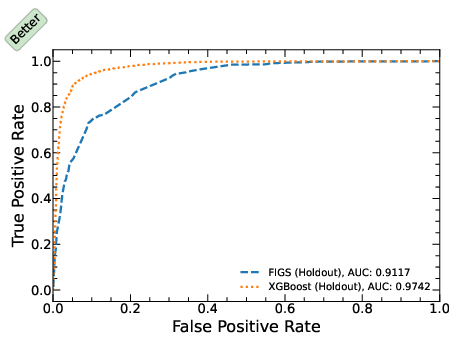

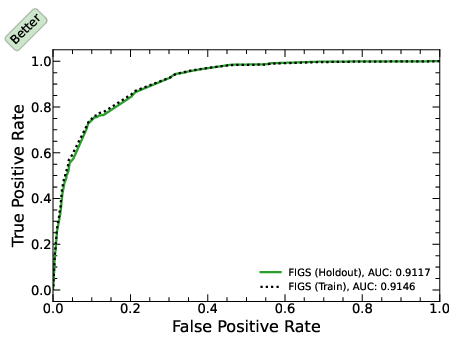

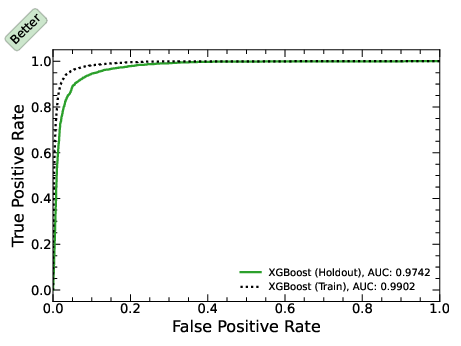

In [27]:
for dataset in datasets[::-1]:
    roc_entry_figs = model_metrics_figs[dataset]['roc_entry']
    roc_entry_figs['c'] = 'C0'
    roc_entry_figs['ls'] = '--'
    roc_entry_xgboost = model_metrics_xgboost[dataset]['roc_entry']
    roc_entry_xgboost['c'] = 'C1'
    roc_entry_xgboost['ls'] = ':'

    models_for_roc = [roc_entry_figs, roc_entry_xgboost]
    plot_rocs(models_for_roc, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, inline=False)
    plot_rocs(models_for_roc, m_path=f'{output}/roc_curves', rndGuess=False, inverse_log=False, precision_recall=True,
              pop_PPV=model_metrics_figs[dataset]['pop_PPV'], y_axis_params={'min': -0.05}, inline=False)

if inline:
    for fname in ['roc_figs_holdout_xgboost_holdout', 'roc_figs_holdout_train', 'roc_xgboost_holdout_train']:
        img = Image(filename=f'{output}/roc_curves/{fname}.pdf')
        display(img)

***
# Tree Plots

In [28]:
color_params_tmp = {'classes': mpl_colors, 'hist_bar': 'C0', 'tick_label': 'black', 'legend_edge': None}
for _ in ['axis_label', 'title', 'legend_title', 'text', 'arrow', 'node_label', 'tick_label', 'leaf_label', 'wedge', 'text_wedge']:
    color_params_tmp[_] = 'black'
color_params = {'colors': color_params_tmp}
dtreeviz_params = {'colors': color_params['colors'], 'leaf_plot_type': 'barh', 'all_axis_spines': False, 'label_fontsize': 10}

In [29]:
x_example = X_train[13]

In [30]:
pd.DataFrame([{col: value for col,value in zip(feat_names, x_example)}])

,x_0_0,x_0_1,x_0_2,x_0_3,x_0_4,x_0_5,x_0_6,x_0_7,x_0_8,x_0_9,...,x_1_5,x_1_6,x_1_7,x_1_8,x_1_9,x_2_0,x_2_1,x_2_2,x_2_3,x_2_4
0,2.442334,-2.469948,0.779209,-0.588849,-0.931177,0.61903,1.465942,5.07889,0.480569,-0.721903,...,-0.917709,0.858035,0.191662,0.747331,0.803049,-0.919831,-1.064932,-1.603046,0.619863,-0.300449


## FIGS

In [31]:
dt_figs_0 = extract_sklearn_tree_from_figs(model_figs, tree_num=0, n_classes=2)
shadow_figs_0 = ShadowSKDTree(dt_figs_0, X_train, y_train, feat_names, 'y', [0, 1])

dt_figs_1 = extract_sklearn_tree_from_figs(model_figs, tree_num=1, n_classes=2)
shadow_figs_1 = ShadowSKDTree(dt_figs_1, X_train, y_train, feat_names, 'y', [0, 1])

### Trees

#### Split Hists

In [32]:
viz = trees.dtreeviz(shadow_figs_0, **dtreeviz_params)
save_dtreeviz(viz, output, 'dtreeviz_figs_0')

In [33]:
viz = trees.dtreeviz(shadow_figs_1, **dtreeviz_params)
save_dtreeviz(viz, output, 'dtreeviz_figs_1')

#### Text

In [34]:
viz = trees.dtreeviz(shadow_figs_0, **dtreeviz_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_figs_0')

In [35]:
viz = trees.dtreeviz(shadow_figs_1, **dtreeviz_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_figs_1')

### Prediction Path

In [36]:
print(trees.explain_prediction_path(shadow_figs_0, x=x_example, explanation_type='plain_english'))

0.02 <= x_1_4 
x_2_0 < -0.61
x_2_1 < 0.05



In [37]:
viz = trees.dtreeviz(shadow_figs_0, **dtreeviz_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_figs_0')

In [38]:
print(trees.explain_prediction_path(shadow_figs_1, x=x_example, explanation_type='plain_english'))

-0.43 <= x_0_2 
x_0_3 < 0.46



In [39]:
viz = trees.dtreeviz(shadow_figs_1, **dtreeviz_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_figs_1')

### Leaf Samples

In [40]:
trees.ctreeviz_leaf_samples(shadow_figs_0, **color_params)
save_plt(output, 'ctreeviz_leaf_samples_figs_0')

In [41]:
trees.ctreeviz_leaf_samples(shadow_figs_1, **color_params)
save_plt(output, 'ctreeviz_leaf_samples_figs_1')

### Leaf Criterion

In [42]:
trees.viz_leaf_criterion(shadow_figs_0, display_type='plot', **color_params)
save_plt(output, 'viz_leaf_criterion_figs_0')

In [43]:
trees.viz_leaf_criterion(shadow_figs_0, display_type='hist', **color_params)
save_plt(output, 'viz_leaf_criterion_hist_figs_0')

In [44]:
trees.viz_leaf_criterion(shadow_figs_1, display_type='plot', **color_params)
save_plt(output, 'viz_leaf_criterion_figs_1')

In [45]:
trees.viz_leaf_criterion(shadow_figs_1, display_type='hist', **color_params)
save_plt(output, 'viz_leaf_criterion_hist_figs_1')

### Splits in Feature Space

In [46]:
trees.ctreeviz_univar(shadow_figs_0, feature_name='x_1_1', **color_params, gtype = 'barstacked', show={'legend', 'splits', 'axis'})
save_plt(output, 'ctreeviz_univar_figs_0')

### Node Sample

In [47]:
trees.describe_node_sample(shadow_figs_0, 18)

,x_0_0,x_0_1,x_0_2,x_0_3,x_0_4,x_0_5,x_0_6,x_0_7,x_0_8,x_0_9,...,x_1_5,x_1_6,x_1_7,x_1_8,x_1_9,x_2_0,x_2_1,x_2_2,x_2_3,x_2_4
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,...,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,1.767229,1.116154,1.083245,1.477000,-0.810264,0.525841,2.012303,0.930154,4.182811,-1.129694,...,-0.239827,0.030528,0.026965,0.005057,-0.033579,0.695488,0.997064,1.398869,-0.566830,-0.008997
std,1.450773,1.576796,1.409163,1.775271,1.714659,1.638135,1.895840,2.721929,1.494092,1.491544,...,0.873685,1.009608,0.973880,0.998447,0.989816,1.062380,0.614211,1.054637,0.359206,1.055266
min,-2.401616,-5.031597,-3.034274,-4.715743,-6.532610,-4.867419,-5.427759,-6.078812,2.363504,-5.196776,...,-2.917652,-3.505779,-3.444223,-3.031508,-3.004628,-2.175032,0.053406,-0.903441,-2.532628,-3.825267
25%,0.874623,0.174982,-0.004228,0.207505,-1.898567,-0.554186,0.856166,-0.794236,3.023169,-2.161035,...,-0.826657,-0.642174,-0.567451,-0.650796,-0.706208,-0.106078,0.545339,0.582967,-0.790365,-0.683467
50%,1.719770,1.190583,1.095149,1.433716,-0.826681,0.611711,2.174741,0.829511,3.795663,-1.280435,...,-0.244170,0.025880,0.068336,-0.017602,-0.049954,0.692166,0.941336,1.369705,-0.544056,-0.001038
75%,2.714320,2.104298,2.110253,2.650330,0.291295,1.708167,3.301559,2.772666,4.964354,-0.258586,...,0.241018,0.684262,0.672124,0.668012,0.589396,1.440461,1.309825,2.097894,-0.298490,0.677038
max,6.481590,6.010321,5.060752,7.156921,3.925822,5.455501,7.688588,9.963754,11.028387,3.838186,...,5.072575,3.955030,3.148567,3.396995,3.062164,3.559361,4.857449,5.089502,0.084606,3.342587


## XGBoost
Tree 0 only

In [48]:
shadow_xgboost_0 = ShadowXGBDTree(model_xgboost, 0, X_train, y_train, feat_names, 'y', [0, 1])

### Trees

#### Split Hists

In [49]:
viz = trees.dtreeviz(shadow_xgboost_0, **dtreeviz_params)
save_dtreeviz(viz, output, 'dtreeviz_xgboost_0')

#### Text

In [50]:
viz = trees.dtreeviz(shadow_xgboost_0, **dtreeviz_params, fancy=False, show_node_labels=True)
save_dtreeviz(viz, output, 'dtreeviz_text_xgboost_0')

### Prediction Path

In [51]:
print(trees.explain_prediction_path(shadow_xgboost_0, x=x_example, explanation_type='plain_english'))

0.05 <= x_2_3  < 1.87



In [52]:
viz = trees.dtreeviz(shadow_xgboost_0, **dtreeviz_params, X=x_example)
save_dtreeviz(viz, output, 'dtreeviz_pred_path_xgboost_0')

### Leaf Samples

In [53]:
trees.ctreeviz_leaf_samples(shadow_xgboost_0, **color_params, label_all_leafs=False)
save_plt(output, 'ctreeviz_leaf_samples_xgboost_0')

Leaf Criterion is not supported for `XGBoost`

### Splits in Feature Space

In [54]:
trees.ctreeviz_univar(shadow_xgboost_0, feature_name='x_1_1', **color_params, gtype = 'barstacked', show={'legend', 'splits', 'axis'})
save_plt(output, 'ctreeviz_univar_xgboost_0')

### Node Sample

In [55]:
trees.describe_node_sample(shadow_xgboost_0, 42)

,x_0_0,x_0_1,x_0_2,x_0_3,x_0_4,x_0_5,x_0_6,x_0_7,x_0_8,x_0_9,...,x_1_5,x_1_6,x_1_7,x_1_8,x_1_9,x_2_0,x_2_1,x_2_2,x_2_3,x_2_4
count,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,...,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000
mean,1.012674,-0.991336,1.155281,-0.432166,-1.683346,0.098674,0.976336,3.442569,0.434084,-0.579965,...,0.933398,0.024972,0.026276,0.054004,-0.000221,-0.099415,1.230998,1.137298,-0.621605,0.028589
std,1.119107,1.469979,1.278005,1.551187,1.555297,1.187498,1.368490,1.280384,1.231001,1.204688,...,1.649190,0.993177,1.016335,1.005863,1.015380,1.089053,0.852878,1.087048,0.448591,1.033237
min,-3.138056,-6.225011,-4.076778,-5.884318,-6.849363,-3.387708,-2.904388,1.871630,-2.224703,-4.493653,...,-3.276613,-3.115242,-3.373070,-3.868328,-3.710716,-1.983176,0.047943,-1.055921,-2.721531,-3.736635
25%,0.245386,-2.017265,0.327914,-1.568224,-2.749472,-0.760154,-0.082223,2.441920,-0.532810,-1.410550,...,-0.274372,-0.687936,-0.671314,-0.622668,-0.726021,-0.879780,0.588146,0.303620,-0.890519,-0.649375
50%,1.037412,-1.012618,1.146609,-0.578757,-1.694313,0.115276,0.844027,3.176878,0.566483,-0.541788,...,0.792990,0.002374,0.028716,0.059855,-0.034026,-0.413216,1.057586,1.036936,-0.557771,0.035026
75%,1.750700,0.068200,1.975192,0.612229,-0.683499,0.920833,1.944449,4.102262,1.479710,0.280212,...,2.028676,0.686250,0.718958,0.701865,0.678744,0.512686,1.688846,1.831311,-0.277202,0.714184
max,4.974638,3.885834,5.427050,4.218194,3.426993,4.517650,6.719807,9.482532,2.360396,3.521284,...,7.036883,2.928519,3.541607,3.183238,3.181252,4.263644,5.238191,5.415948,0.105382,3.349577


***
# Tree Functions

## FIGS

In [56]:
expr_figs_0 = skompile(dt_figs_0.predict_proba, feat_names)

In [57]:
print(expr_figs_0.to('sqlalchemy/sqlite', component=1, assign_to='tree_0'))

SELECT CASE WHEN (x_2_1 <= 0.047700537368655205) THEN CASE WHEN (x_2_0 <= -0.6084129214286804) THEN CASE WHEN (x_1_4 <= 0.017502836883068085) THEN CASE WHEN (x_0_7 <= 1.3998010754585266) THEN 0.11379529561347743 ELSE 0.38880248833592534 END ELSE 0.032956362805574596 END ELSE 0.0026475779564620514 END ELSE CASE WHEN (x_0_8 <= 2.363405704498291) THEN CASE WHEN (x_0_7 <= 1.8703043460845947) THEN 0.1812694032424974 ELSE 0.36647904940587867 END ELSE CASE WHEN (x_1_0 <= 0.3394070416688919) THEN CASE WHEN (x_2_0 <= -0.04638334736227989) THEN 0.5054517133956387 ELSE 0.7712753555607368 END ELSE CASE WHEN (x_1_1 <= 2.0868066549301147) THEN 0.27399165507649514 ELSE 0.5887949260042283 END END END END AS tree_0 
FROM data


In [58]:
print(expr_figs_0.to('python/code'))

((((np.array([0.8862047043865225, 0.11379529561347743]) if x_0_7 <= 
    1.3998010754585266 else np.array([0.6111975116640747, 
    0.38880248833592534])) if x_1_4 <= 0.017502836883068085 else np.
    array([0.9670436371944254, 0.032956362805574596])) if x_2_0 <= 
    -0.6084129214286804 else np.array([0.9973524220435379, 
    0.0026475779564620514])) if x_2_1 <= 0.047700537368655205 else (np.
    array([0.8187305967575026, 0.1812694032424974]) if x_0_7 <= 
    1.8703043460845947 else np.array([0.6335209505941213, 
    0.36647904940587867])) if x_0_8 <= 2.363405704498291 else (np.array
    ([0.4945482866043614, 0.5054517133956387]) if x_2_0 <= 
    -0.04638334736227989 else np.array([0.22872464443926324, 
    0.7712753555607368])) if x_1_0 <= 0.3394070416688919 else np.array(
    [0.7260083449235049, 0.27399165507649514]) if x_1_1 <= 
    2.0868066549301147 else np.array([0.41120507399577166, 
    0.5887949260042283]))



In [59]:
expr_figs_1 = skompile(dt_figs_1.predict_proba, feat_names)

In [60]:
print(expr_figs_1.to('sqlalchemy/sqlite', component=1, assign_to='tree_1'))

SELECT CASE WHEN (x_0_2 <= -0.43244342505931854) THEN 0.050912259987068116 ELSE CASE WHEN (x_0_3 <= 0.4551866203546524) THEN 0.1490697322644078 ELSE CASE WHEN (x_2_1 <= -0.31738142669200897) THEN 0.04208863699711976 ELSE CASE WHEN (x_1_3 <= -0.2993980050086975) THEN CASE WHEN (x_0_0 <= -0.9580468833446503) THEN CASE WHEN (x_1_2 <= 0.35873670876026154) THEN 0.18310858765081617 ELSE 0.7016574585635359 END ELSE CASE WHEN (x_2_0 <= 0.15202737599611282) THEN 0.7007730786721237 ELSE 0.7108632796365139 END END ELSE CASE WHEN (x_1_4 <= 0.16462678462266922) THEN CASE WHEN (x_0_5 <= 0.9298670291900635) THEN CASE WHEN (x_2_0 <= 0.5672585964202881) THEN 0.746875 ELSE 0.3492462311557789 END ELSE 0.2857142857142857 END ELSE CASE WHEN (x_1_5 <= -0.47995996475219727) THEN 0.5458461538461539 ELSE 0.0855640535372849 END END END END END END AS tree_1 
FROM data


In [61]:
print(expr_figs_1.to('python/code'))

(np.array([0.9490877400129318, 0.050912259987068116]) if x_0_2 <= 
    -0.43244342505931854 else np.array([0.8509302677355922, 
    0.1490697322644078]) if x_0_3 <= 0.4551866203546524 else np.array([
    0.9579113630028803, 0.04208863699711976]) if x_2_1 <= 
    -0.31738142669200897 else ((np.array([0.8168914123491838, 
    0.18310858765081617]) if x_1_2 <= 0.35873670876026154 else np.array
    ([0.2983425414364641, 0.7016574585635359])) if x_0_0 <= 
    -0.9580468833446503 else np.array([0.2992269213278763, 
    0.7007730786721237]) if x_2_0 <= 0.15202737599611282 else np.array(
    [0.28913672036348614, 0.7108632796365139])) if x_1_3 <= 
    -0.2993980050086975 else ((np.array([0.253125, 0.746875]) if x_2_0 <=
    0.5672585964202881 else np.array([0.6507537688442211, 
    0.3492462311557789])) if x_0_5 <= 0.9298670291900635 else np.array(
    [0.7142857142857143, 0.2857142857142857])) if x_1_4 <= 
    0.16462678462266922 else np.array([0.45415384615384613, 
    0.5458461538461539]) i

## XGBoost
Text of Tree 0 only, consider using [xgb2sql](https://github.com/Chryzanthemum/xgb2sql) if SQL is needed.

In [62]:
print(model_xgboost.get_booster()[0].get_dump(dump_format='text')[0])

0:[x_2_1<0.0476587564] yes=1,no=2,missing=1
	1:[x_2_0<-0.645031273] yes=3,no=4,missing=3
		3:[x_1_4<0.0179839358] yes=7,no=8,missing=7
			7:[x_0_2<0.557516992] yes=15,no=16,missing=15
				15:[x_0_7<1.61057043] yes=29,no=30,missing=29
					29:[x_0_5<0.0603608899] yes=53,no=54,missing=53
						53:leaf=-0.451428592
						54:leaf=-0.546934724
					30:[x_2_1<-1.1075592] yes=55,no=56,missing=55
						55:leaf=-0.499441355
						56:leaf=-0.160159379
				16:[x_0_0<-0.517694712] yes=31,no=32,missing=31
					31:[x_0_7<2.26842213] yes=57,no=58,missing=57
						57:leaf=-0.453658551
						58:leaf=0.0285714306
					32:[x_1_0<-0.46045959] yes=59,no=60,missing=59
						59:leaf=-0.272289157
						60:leaf=0.276237637
			8:[x_1_3<-0.922470212] yes=17,no=18,missing=17
				17:[x_1_0<-0.379907161] yes=33,no=34,missing=33
					33:[x_0_3<0.779166937] yes=61,no=62,missing=61
						61:leaf=-0.151401877
						62:leaf=0.400000036
					34:[x_0_2<0.0654732138] yes=63,no=64,missing=63
						63:leaf=-0.520000041
					